In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re

In [3]:
data=pd.read_csv('preprocessing_2.csv')

In [4]:
data.head()

,Unnamed: 0,Unnamed: 0.1,label,p_title,sent_length,word_length,Stops_ratio,Num_Punctuation,category_Berita,category_Ekonomi&Bisnis,...,source_fimela.com,source_kapanlagi.com,source_liputan6.com,source_okezone.com,source_posmetro-medan.com,source_republika.co.id,source_sindonews.com,source_tempo.co,source_tribunnews.com,source_wowkeren.com
0,0,0,non-clickbait,masuk radar pilwalkot medan menantu jokowi ber...,10,5.800000,0.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,non-clickbait,malaysia sudutkan ri isu kabut asap invasi babi,8,5.111111,0.111111,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,clickbait,viral driver ojol bekasi pesanan makanan pakai...,8,5.300000,0.200000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,non-clickbait,kemensos salurkan rp m korban kerusuhan sosial...,8,5.100000,0.200000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,clickbait,terkait mayat bayi mengenaskan tangerang pria ...,8,6.400000,0.200000,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
def category(x):
    if x=='clickbait':
        return 1
    else :
        return 0

In [6]:
data.label=data.label.apply(lambda x:category(x))

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['Unnamed: 0','Unnamed: 0.1','label']), data['label'], test_size=1/3,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test, test_size=0.8, random_state=42)

In [12]:
X_train.sample()

,p_title,sent_length,word_length,Stops_ratio,Num_Punctuation,category_Berita,category_Ekonomi&Bisnis,category_Lain,category_Lifestyle,category_Olahraga,...,source_fimela.com,source_kapanlagi.com,source_liputan6.com,source_okezone.com,source_posmetro-medan.com,source_republika.co.id,source_sindonews.com,source_tempo.co,source_tribunnews.com,source_wowkeren.com
9388,thiago silva neymar andalan psg,9,5.111111,0.444444,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


# Embedding

In [9]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
# Limit on the number of features to K features.
TOP_K = 20000

# Limit on the length of text sequences. 
# Sequences longer than this will be truncated.
# and less than it will be padded
MAX_SEQUENCE_LENGTH = 20

class CustomTokenizer:
    def __init__(self, train_texts):
        self.train_texts = train_texts
        self.tokenizer = Tokenizer(num_words=TOP_K)
        
    def train_tokenize(self):
        # Get max sequence length.
        max_length = len(max(self.train_texts , key=len))
        self.max_length = min(max_length, MAX_SEQUENCE_LENGTH)
    
        # Create vocabulary with training texts.
        self.tokenizer.fit_on_texts(self.train_texts)
        
    def vectorize_input(self, tweets):
        # Vectorize training and validation texts.
        
        tweets = self.tokenizer.texts_to_sequences(tweets)
        # Fix sequence length to max value. Sequences shorter than the length are
        # padded in the beginning and sequences longer are truncated
        # at the beginning.
        tweets = sequence.pad_sequences(tweets, maxlen=self.max_length, truncating='post',padding='post')
        return tweets
    
tokenizer = CustomTokenizer(train_texts = X_train['p_title'])
# fit o the train
tokenizer.train_tokenize()
tokenized_train = tokenizer.vectorize_input(X_train['p_title'])
tokenized_val=tokenizer.vectorize_input(X_val['p_title'])
tokenized_test = tokenizer.vectorize_input(X_test['p_title'])

Using TensorFlow backend.


In [10]:
import tqdm
glove_file='id_wiki_100.txt'
EMBEDDING_VECTOR_LENGTH = 100
def construct_embedding_matrix(glove_file, word_index):
    embedding_dict = {}
    with open(glove_file, 'r', errors="ignore") as f:
        for line in f:
            values=line.split()
            # get the word
            word=values[0]
            if word in word_index.keys():
                # get the vector
                vector = np.asarray(values[1:], 'float32')
                embedding_dict[word] = vector
    ###  oov words (out of vacabulary words) will be mapped to 0 vectors

    num_words=len(word_index)+1
    #initialize it to 0
    embedding_matrix=np.zeros((num_words, EMBEDDING_VECTOR_LENGTH))

    for word,i in tqdm.tqdm(word_index.items()):
        if i < num_words:
            vect=embedding_dict.get(word, [])
            if len(vect)>0:
                embedding_matrix[i] = vect[:EMBEDDING_VECTOR_LENGTH]
    return embedding_matrix
  
embedding_matrix =  construct_embedding_matrix(glove_file, tokenizer.tokenizer.word_index)

100%|████████████████████████████████████████████████████████████████████████| 14083/14083 [00:00<00:00, 164191.50it/s]


# Self Attentive Network + Structured Variable

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras import backend as K
from attention import Attention

In [12]:
tf.compat.v1.disable_eager_execution()

In [13]:
class attention(tf.keras.layers.Layer): 
    def __init__(self):    
        super(attention, self).__init__()
        
    def build(self, input_shape):
        self.num_dim_perword = input_shape[-1] ##Last value of inp:256
        self.W_1 = self.add_weight(shape=(self.num_dim_perword,self.num_dim_perword),initializer=tf.keras.initializers.GlorotNormal(),trainable=True)
        self.W_2 = self.add_weight(shape=(self.num_dim_perword,1),initializer=tf.keras.initializers.GlorotNormal(),trainable=True)
        super(attention, self).build(input_shape)
        
    def call(self, x):
        e = K.dot(K.tanh(K.dot(x,self.W_1)),self.W_2)
        a = K.softmax(e, axis=-1)
        output = x*a
        return K.sum(output, axis=1)

In [13]:
inputs_word = tf.keras.Input(shape=(20,))
word = tf.keras.layers.Embedding(len(tokenizer.tokenizer.word_index)+1,
                    100,
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=20,trainable=False)(inputs_word)
word=tf.keras.layers.Dropout(0.2)(word)
word=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2,return_sequences=True),merge_mode='concat')(word)
word=Attention()(word)
word = tf.keras.Model(inputs=inputs_word, outputs=word)
inputs_other= tf.keras.Input(shape=(25,))
model=tf.keras.layers.concatenate([word.output, inputs_other])
model=tf.keras.layers.Dense(1,activation='sigmoid')(model)
model= tf.keras.Model(inputs=[word.input, inputs_other], outputs=model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 100)      1408400     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 20, 100)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 128)      84480       dropout_1[0][0]                  
____________________________________________________________________________________________

In [14]:
optimizer= tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=['accuracy'])

In [15]:
i_train = [tokenized_train,X_train.drop(columns=['p_title']).to_numpy()]
i_val= [tokenized_val,X_val.drop(columns=['p_title']).to_numpy()]
i_test= [tokenized_test,X_test.drop(columns=['p_title']).to_numpy()]

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='auto')
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
histori = model.fit(x=i_train,y=y_train,validation_data=(i_val,y_val),
                    epochs=20, batch_size=64, callbacks=[callback],
                    verbose=2)

Epoch 1/20
157/157 - 17s - loss: 0.5512 - accuracy: 0.7265 - val_loss: 0.4848 - val_accuracy: 0.7690
Epoch 2/20
157/157 - 10s - loss: 0.4714 - accuracy: 0.7730 - val_loss: 0.4444 - val_accuracy: 0.7910
Epoch 3/20
157/157 - 10s - loss: 0.4418 - accuracy: 0.7942 - val_loss: 0.4340 - val_accuracy: 0.8010
Epoch 4/20
157/157 - 10s - loss: 0.4235 - accuracy: 0.8006 - val_loss: 0.4270 - val_accuracy: 0.8020
Epoch 5/20
157/157 - 10s - loss: 0.4108 - accuracy: 0.8086 - val_loss: 0.4285 - val_accuracy: 0.7980
Epoch 6/20
157/157 - 10s - loss: 0.4011 - accuracy: 0.8169 - val_loss: 0.4202 - val_accuracy: 0.8130
Epoch 7/20
157/157 - 10s - loss: 0.3851 - accuracy: 0.8257 - val_loss: 0.4340 - val_accuracy: 0.8060
Epoch 8/20
157/157 - 10s - loss: 0.3782 - accuracy: 0.8326 - val_loss: 0.4202 - val_accuracy: 0.8090
Epoch 9/20
157/157 - 10s - loss: 0.3693 - accuracy: 0.8329 - val_loss: 0.4296 - val_accuracy: 0.7950
Epoch 10/20
157/157 - 10s - loss: 0.3661 - accuracy: 0.8296 - val_loss: 0.4377 - val_accura

In [59]:
import matplotlib.pyplot as plt

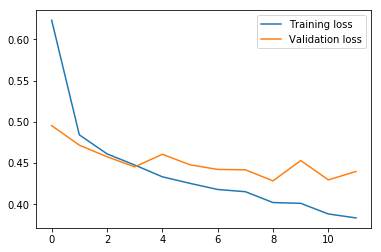

In [60]:
plt.plot(histori.history['loss'],label='Training loss')
plt.plot(histori.history['val_loss'],label='Validation loss')
plt.legend()
plt.show()

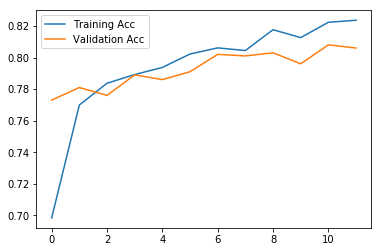

In [61]:
plt.plot(histori.history['accuracy'],label='Training Acc')
plt.plot(histori.history['val_accuracy'],label='Validation Acc')
plt.legend()
plt.show()

In [62]:
a_mean,a_std=np.mean(histori.history['accuracy']),np.std(histori.history['accuracy'])
l_mean,l_std=np.mean(histori.history['loss']),np.std(histori.history['loss'])
av_mean,av_std=np.mean(histori.history['val_accuracy']),np.std(histori.history['val_accuracy'])
lv_mean,lv_std=np.mean(histori.history['val_loss']),np.std(histori.history['val_loss'])
print('RNN (SA-BiLSTM + Structured Data)')
print('Training')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(a_mean,a_std,l_mean,l_std))
print('Validation')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(av_mean,av_std,lv_mean,lv_std))

RNN (SA-BiLSTM + Structured Data)
Training
Accuracy : 0.794 (+-0.033) Loss : 0.440 (+-0.062)
Validation
Accuracy : 0.793 (+-0.011) Loss : 0.451 (+-0.018)


In [17]:
def float_int(x):
    if x-int(x)>=0.5:
        return 1
    else :
        return 0

In [21]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in model.predict(i_test)])
test_loss,test_accuracy=model.evaluate(i_test,y_test)
print('Test Loss : %0.3f'%test_loss)
print('Test Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

125/125 [==============================] - ETA: 2s - loss: 0.3396 - accuracy: 0.81 - ETA: 1s - loss: 0.4385 - accuracy: 0.78 - ETA: 0s - loss: 0.4708 - accuracy: 0.77 - ETA: 0s - loss: 0.4413 - accuracy: 0.80 - ETA: 0s - loss: 0.4418 - accuracy: 0.79 - ETA: 0s - loss: 0.4362 - accuracy: 0.80 - ETA: 0s - loss: 0.4508 - accuracy: 0.79 - ETA: 0s - loss: 0.4607 - accuracy: 0.79 - ETA: 0s - loss: 0.4604 - accuracy: 0.79 - ETA: 0s - loss: 0.4499 - accuracy: 0.79 - ETA: 0s - loss: 0.4523 - accuracy: 0.79 - ETA: 0s - loss: 0.4579 - accuracy: 0.79 - ETA: 0s - loss: 0.4512 - accuracy: 0.79 - ETA: 0s - loss: 0.4485 - accuracy: 0.79 - ETA: 0s - loss: 0.4549 - accuracy: 0.79 - ETA: 0s - loss: 0.4549 - accuracy: 0.79 - ETA: 0s - loss: 0.4523 - accuracy: 0.79 - ETA: 0s - loss: 0.4505 - accuracy: 0.79 - ETA: 0s - loss: 0.4517 - accuracy: 0.79 - ETA: 0s - loss: 0.4518 - accuracy: 0.79 - ETA: 0s - loss: 0.4524 - accuracy: 0.79 - 1s 9ms/step - loss: 0.4524 - accuracy: 0.7922
Test Loss : 0.452
Test Accura

In [22]:
print('Test Loss : %0.3f'%test_loss)
print('Test Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Test Loss : 0.452
Test Accuracy : 0.792
F1-Score : 0.743
              precision    recall  f1-score   support

           0       0.81      0.84      0.83      2334
           1       0.77      0.72      0.74      1666

    accuracy                           0.79      4000
   macro avg       0.79      0.78      0.78      4000
weighted avg       0.79      0.79      0.79      4000



In [23]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in model.predict(i_val)])
test_loss,test_accuracy=model.evaluate(i_val,y_val)

32/32 [==============================] - ETA: 0s - loss: 0.4624 - accuracy: 0.78 - ETA: 0s - loss: 0.4633 - accuracy: 0.79 - ETA: 0s - loss: 0.4067 - accuracy: 0.82 - ETA: 0s - loss: 0.4415 - accuracy: 0.79 - ETA: 0s - loss: 0.4231 - accuracy: 0.80 - 0s 8ms/step - loss: 0.4322 - accuracy: 0.8010


In [24]:
print('Validation Loss : %0.3f'%test_loss)
print('Validation Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_val,y_pred))
print(classification_report(y_val,y_pred))

Validation Loss : 0.432
Validation Accuracy : 0.801
F1-Score : 0.752
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       591
           1       0.77      0.74      0.75       409

    accuracy                           0.80      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.80      0.80      0.80      1000



In [25]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in model.predict(i_train)])
test_loss,test_accuracy=model.evaluate(i_train,y_train)

313/313 [==============================] - ETA: 8s - loss: 0.3012 - accuracy: 0.87 - ETA: 3s - loss: 0.2694 - accuracy: 0.88 - ETA: 2s - loss: 0.2586 - accuracy: 0.88 - ETA: 2s - loss: 0.2817 - accuracy: 0.87 - ETA: 2s - loss: 0.2707 - accuracy: 0.88 - ETA: 2s - loss: 0.2672 - accuracy: 0.88 - ETA: 2s - loss: 0.2720 - accuracy: 0.88 - ETA: 2s - loss: 0.2662 - accuracy: 0.88 - ETA: 2s - loss: 0.2660 - accuracy: 0.88 - ETA: 2s - loss: 0.2664 - accuracy: 0.88 - ETA: 2s - loss: 0.2652 - accuracy: 0.88 - ETA: 2s - loss: 0.2677 - accuracy: 0.88 - ETA: 2s - loss: 0.2648 - accuracy: 0.89 - ETA: 2s - loss: 0.2682 - accuracy: 0.89 - ETA: 1s - loss: 0.2689 - accuracy: 0.88 - ETA: 1s - loss: 0.2729 - accuracy: 0.88 - ETA: 1s - loss: 0.2728 - accuracy: 0.88 - ETA: 1s - loss: 0.2731 - accuracy: 0.88 - ETA: 1s - loss: 0.2775 - accuracy: 0.88 - ETA: 1s - loss: 0.2775 - accuracy: 0.88 - ETA: 1s - loss: 0.2764 - accuracy: 0.88 - ETA: 1s - loss: 0.2733 - accuracy: 0.89 - ETA: 1s - loss: 0.2725 - accuracy

In [26]:
print('training Loss : %0.3f'%test_loss)
print('training Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_train,y_pred))
print(classification_report(y_train,y_pred))

training Loss : 0.268
training Accuracy : 0.893
F1-Score : 0.869
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5789
           1       0.90      0.84      0.87      4211

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



# Self Attentive Network

In [23]:
class attention(tf.keras.layers.Layer): 
    def __init__(self):
        super(attention, self).__init__()
        
    def build(self, input_shape):
        self.num_dim_perword = input_shape[-1] ##Last value of inp:256
        self.W1 = self.add_weight(shape=(self.num_dim_perword,self.num_dim_perword),initializer=tf.keras.initializers.GlorotNormal(),trainable=True)
        self.W2 = self.add_weight(shape=(self.num_dim_perword,1),initializer=tf.keras.initializers.GlorotNormal(),trainable=True)
        super(attention, self).build(input_shape)
        
    def call(self, x):
        e = K.dot(K.tanh(K.dot(x,self.W1)),self.W2)
        a = K.softmax(e,axis=-1)
        output = x*a
        return K.sum(output, axis=1)

In [28]:
state_size = 64
dropout= 0.2
optimizer= tf.keras.optimizers.Adam(learning_rate=0.005)
mods1=tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.tokenizer.word_index)+1,
                    100,
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=20,trainable=False),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size, dropout=dropout, recurrent_dropout=0.3,return_sequences=True)),
    Attention(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
mods1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=['accuracy'])
mods1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 100)           1408400   
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 128)           84480     
_________________________________________________________________
last_hidden_state (Lambda)   (None, 128)               0         
_________________________________________________________________
attention_score_vec (Dense)  (None, 20, 128)           16384     
_________________________________________________________________
attention_score (Dot)        (None, 20)                0         
_________________________________________________________________
attention_weight (Activation (None, 20)                0

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='auto')
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
historie = mods1.fit(tokenized_train,y_train,validation_data=(tokenized_val,y_val),
                    epochs=20, batch_size=128, callbacks=[callback],
                    verbose=2)

Epoch 1/20
79/79 - 15s - loss: 0.5873 - accuracy: 0.6944 - val_loss: 0.5483 - val_accuracy: 0.7420
Epoch 2/20
79/79 - 8s - loss: 0.5458 - accuracy: 0.7303 - val_loss: 0.5384 - val_accuracy: 0.7480
Epoch 3/20
79/79 - 8s - loss: 0.5312 - accuracy: 0.7362 - val_loss: 0.5228 - val_accuracy: 0.7430
Epoch 4/20
79/79 - 8s - loss: 0.5142 - accuracy: 0.7506 - val_loss: 0.5190 - val_accuracy: 0.7580
Epoch 5/20
79/79 - 8s - loss: 0.5020 - accuracy: 0.7595 - val_loss: 0.5248 - val_accuracy: 0.7620
Epoch 6/20
79/79 - 8s - loss: 0.4884 - accuracy: 0.7640 - val_loss: 0.5333 - val_accuracy: 0.7510
Epoch 7/20
79/79 - 8s - loss: 0.4750 - accuracy: 0.7730 - val_loss: 0.5109 - val_accuracy: 0.7610
Epoch 8/20
79/79 - 8s - loss: 0.4645 - accuracy: 0.7825 - val_loss: 0.5152 - val_accuracy: 0.7490
Epoch 9/20
79/79 - 8s - loss: 0.4566 - accuracy: 0.7908 - val_loss: 0.5392 - val_accuracy: 0.7570
Epoch 10/20
79/79 - 8s - loss: 0.4511 - accuracy: 0.7886 - val_loss: 0.5307 - val_accuracy: 0.7560


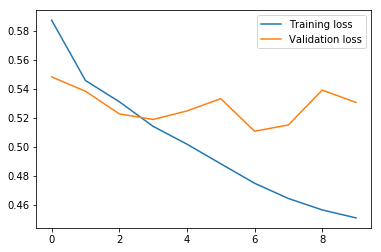

In [30]:
plt.plot(historie.history['loss'],label='Training loss')
plt.plot(historie.history['val_loss'],label='Validation loss')
plt.legend()
plt.show()

In [31]:
a_mean,a_std=np.mean(historie.history['accuracy']),np.std(historie.history['accuracy'])
l_mean,l_std=np.mean(historie.history['loss']),np.std(historie.history['loss'])
av_mean,av_std=np.mean(historie.history['val_accuracy']),np.std(historie.history['val_accuracy'])
lv_mean,lv_std=np.mean(historie.history['val_loss']),np.std(historie.history['val_loss'])
print('RNN (SA-BiLSTM)')
print('Training')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(a_mean,a_std,l_mean,l_std))
print('Validation')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(av_mean,av_std,lv_mean,lv_std))

RNN (SA-BiLSTM)
Training
Accuracy : 0.757 (+-0.029) Loss : 0.502 (+-0.041)
Validation
Accuracy : 0.753 (+-0.007) Loss : 0.528 (+-0.011)


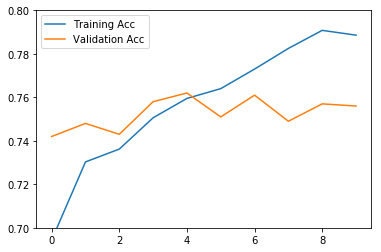

In [32]:
plt.plot(historie.history['accuracy'],label='Training Acc')
plt.plot(historie.history['val_accuracy'],label='Validation Acc')
plt.legend()
plt.ylim(0.7,0.8)
plt.show()

In [36]:
def float_int(x):
    if x-int(x)>=0.5:
        return 1
    else :
        return 0
y_pred=np.array([[float_int(i[0])] for i in mods1.predict(tokenized_test)])

In [40]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in mods1.predict(tokenized_train)])
test_loss,test_accuracy=mods1.evaluate(tokenized_train,y_train)

313/313 [==============================] - ETA: 7s - loss: 0.3082 - accuracy: 0.87 - ETA: 2s - loss: 0.3278 - accuracy: 0.85 - ETA: 2s - loss: 0.3317 - accuracy: 0.86 - ETA: 2s - loss: 0.3486 - accuracy: 0.84 - ETA: 2s - loss: 0.3453 - accuracy: 0.85 - ETA: 2s - loss: 0.3493 - accuracy: 0.85 - ETA: 2s - loss: 0.3458 - accuracy: 0.85 - ETA: 2s - loss: 0.3422 - accuracy: 0.85 - ETA: 2s - loss: 0.3437 - accuracy: 0.85 - ETA: 1s - loss: 0.3425 - accuracy: 0.85 - ETA: 1s - loss: 0.3426 - accuracy: 0.86 - ETA: 1s - loss: 0.3422 - accuracy: 0.86 - ETA: 1s - loss: 0.3425 - accuracy: 0.86 - ETA: 1s - loss: 0.3439 - accuracy: 0.85 - ETA: 1s - loss: 0.3442 - accuracy: 0.85 - ETA: 1s - loss: 0.3442 - accuracy: 0.85 - ETA: 1s - loss: 0.3459 - accuracy: 0.85 - ETA: 1s - loss: 0.3482 - accuracy: 0.85 - ETA: 1s - loss: 0.3469 - accuracy: 0.85 - ETA: 1s - loss: 0.3431 - accuracy: 0.85 - ETA: 1s - loss: 0.3440 - accuracy: 0.85 - ETA: 1s - loss: 0.3455 - accuracy: 0.85 - ETA: 1s - loss: 0.3463 - accuracy

In [41]:
print('training Loss : %0.3f'%test_loss)
print('training Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_train,y_pred))
print(classification_report(y_train,y_pred))

training Loss : 0.339
training Accuracy : 0.861
F1-Score : 0.823
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      5789
           1       0.89      0.77      0.82      4211

    accuracy                           0.86     10000
   macro avg       0.87      0.85      0.85     10000
weighted avg       0.86      0.86      0.86     10000



In [42]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in mods1.predict(tokenized_val)])
test_loss,test_accuracy=mods1.evaluate(tokenized_val,y_val)

32/32 [==============================] - ETA: 0s - loss: 0.4827 - accuracy: 0.81 - ETA: 0s - loss: 0.5970 - accuracy: 0.74 - ETA: 0s - loss: 0.5721 - accuracy: 0.74 - ETA: 0s - loss: 0.5718 - accuracy: 0.74 - ETA: 0s - loss: 0.5421 - accuracy: 0.75 - ETA: 0s - loss: 0.5307 - accuracy: 0.75 - 0s 9ms/step - loss: 0.5307 - accuracy: 0.7560


In [43]:
print('Validation Loss : %0.3f'%test_loss)
print('Validation Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_val,y_pred))
print(classification_report(y_val,y_pred))

Validation Loss : 0.531
Validation Accuracy : 0.756
F1-Score : 0.674
              precision    recall  f1-score   support

           0       0.76      0.85      0.81       591
           1       0.74      0.62      0.67       409

    accuracy                           0.76      1000
   macro avg       0.75      0.73      0.74      1000
weighted avg       0.75      0.76      0.75      1000



In [44]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in mods1.predict(tokenized_test)])
test_loss,test_accuracy=mods1.evaluate(tokenized_test,y_test)

125/125 [==============================] - ETA: 3s - loss: 0.4862 - accuracy: 0.81 - ETA: 1s - loss: 0.5709 - accuracy: 0.75 - ETA: 1s - loss: 0.5751 - accuracy: 0.74 - ETA: 0s - loss: 0.5539 - accuracy: 0.75 - ETA: 0s - loss: 0.5328 - accuracy: 0.75 - ETA: 0s - loss: 0.5390 - accuracy: 0.76 - ETA: 0s - loss: 0.5495 - accuracy: 0.75 - ETA: 0s - loss: 0.5491 - accuracy: 0.75 - ETA: 0s - loss: 0.5568 - accuracy: 0.75 - ETA: 0s - loss: 0.5478 - accuracy: 0.75 - ETA: 0s - loss: 0.5430 - accuracy: 0.75 - ETA: 0s - loss: 0.5524 - accuracy: 0.74 - ETA: 0s - loss: 0.5583 - accuracy: 0.74 - ETA: 0s - loss: 0.5529 - accuracy: 0.75 - ETA: 0s - loss: 0.5566 - accuracy: 0.74 - ETA: 0s - loss: 0.5644 - accuracy: 0.74 - ETA: 0s - loss: 0.5627 - accuracy: 0.74 - ETA: 0s - loss: 0.5607 - accuracy: 0.74 - ETA: 0s - loss: 0.5553 - accuracy: 0.74 - ETA: 0s - loss: 0.5563 - accuracy: 0.74 - ETA: 0s - loss: 0.5551 - accuracy: 0.74 - ETA: 0s - loss: 0.5562 - accuracy: 0.74 - 1s 10ms/step - loss: 0.5571 - acc

In [45]:
print('Test Loss : %0.3f'%test_loss)
print('Test Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Test Loss : 0.557
Test Accuracy : 0.742
F1-Score : 0.665
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      2334
           1       0.72      0.62      0.66      1666

    accuracy                           0.74      4000
   macro avg       0.74      0.72      0.73      4000
weighted avg       0.74      0.74      0.74      4000



# BiLSTM

In [31]:
state_size = 64
dropout= 0.2
optimizer= tf.keras.optimizers.Adam(learning_rate=0.005)
mods=tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.tokenizer.word_index)+1,
                    100,
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=20,trainable=False),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size, dropout=dropout, recurrent_dropout=0.3)),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])
mods.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=['accuracy'])
mods.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 100)           1408400   
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,493,009
Trainable params: 84,609
Non-trainable params: 1,408,400
_________________________________________________________________


In [32]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='auto')
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
histories = mods.fit(tokenized_train,y_train,validation_data=(tokenized_val,y_val),
                    epochs=20, batch_size=64, callbacks=[callback],
                    verbose=2)

Train on 10000 samples, validate on 1000 samples
Epoch 1/20
10000/10000 - 13s - loss: 0.5738 - accuracy: 0.7100 - val_loss: 0.5346 - val_accuracy: 0.7380
Epoch 2/20
10000/10000 - 10s - loss: 0.5392 - accuracy: 0.7348 - val_loss: 0.5241 - val_accuracy: 0.7320
Epoch 3/20
10000/10000 - 10s - loss: 0.5141 - accuracy: 0.7470 - val_loss: 0.5313 - val_accuracy: 0.7410
Epoch 4/20
10000/10000 - 10s - loss: 0.4982 - accuracy: 0.7591 - val_loss: 0.5233 - val_accuracy: 0.7520
Epoch 5/20
10000/10000 - 10s - loss: 0.4850 - accuracy: 0.7689 - val_loss: 0.5184 - val_accuracy: 0.7470
Epoch 6/20
10000/10000 - 10s - loss: 0.4717 - accuracy: 0.7778 - val_loss: 0.5283 - val_accuracy: 0.7620
Epoch 7/20
10000/10000 - 10s - loss: 0.4652 - accuracy: 0.7810 - val_loss: 0.5153 - val_accuracy: 0.7720
Epoch 8/20
10000/10000 - 9s - loss: 0.4537 - accuracy: 0.7836 - val_loss: 0.5400 - val_accuracy: 0.7530
Epoch 9/20
10000/10000 - 10s - loss: 0.4483 - accuracy: 0.7893 - val_loss: 0.5356 - val_accuracy: 0.7450
Epoch 1

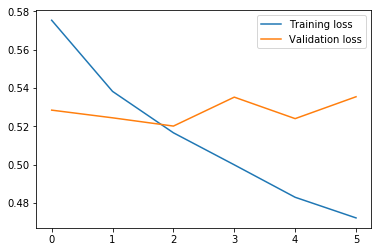

In [79]:
plt.plot(histories.history['loss'],label='Training loss')
plt.plot(histories.history['val_loss'],label='Validation loss')
plt.legend()
plt.show()

In [80]:
a_mean,a_std=np.mean(histories.history['accuracy']),np.std(histories.history['accuracy'])
l_mean,l_std=np.mean(histories.history['loss']),np.std(histories.history['loss'])
av_mean,av_std=np.mean(histories.history['val_accuracy']),np.std(histories.history['val_accuracy'])
lv_mean,lv_std=np.mean(histories.history['val_loss']),np.std(histories.history['val_loss'])
print('RNN (BiLSTM)')
print('Training')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(a_mean,a_std,l_mean,l_std))
print('Validation')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(av_mean,av_std,lv_mean,lv_std))

RNN (BiLSTM)
Training
Accuracy : 0.750 (+-0.024) Loss : 0.514 (+-0.035)
Validation
Accuracy : 0.744 (+-0.006) Loss : 0.528 (+-0.006)


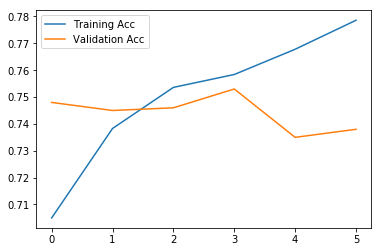

In [81]:
plt.plot(histories.history['accuracy'],label='Training Acc')
plt.plot(histories.history['val_accuracy'],label='Validation Acc')
plt.legend()
plt.show()

In [92]:
def float_int(x):
    if x-int(x)>=0.5:
        return 1
    else :
        return 0
y_pred=np.array([[float_int(i[0])] for i in mods.predict(tokenized_test)])

In [33]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in mods.predict(tokenized_train)])
test_loss,test_accuracy=mods.evaluate(tokenized_train,y_train)
print('Training Loss : %0.3f'%test_loss)
print('Training Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_train,y_pred))
print(classification_report(y_train,y_pred))

Training Loss : 0.314
Training Accuracy : 0.867
F1-Score : 0.834
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      5789
           1       0.88      0.79      0.83      4211

    accuracy                           0.87     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.87      0.87     10000



In [34]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in mods.predict(tokenized_val)])
test_loss,test_accuracy=mods.evaluate(tokenized_val,y_val)
print('Validation Loss : %0.3f'%test_loss)
print('Validation Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_val,y_pred))
print(classification_report(y_val,y_pred))

Validation Loss : 0.539
Validation Accuracy : 0.753
F1-Score : 0.675
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       591
           1       0.73      0.63      0.68       409

    accuracy                           0.75      1000
   macro avg       0.75      0.73      0.74      1000
weighted avg       0.75      0.75      0.75      1000



In [35]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in mods.predict(tokenized_test)])
test_loss,test_accuracy=mods.evaluate(tokenized_test,y_test)
print('Test Loss : %0.3f'%test_loss)
print('Test Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Test Loss : 0.599
Test Accuracy : 0.729
F1-Score : 0.657
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      2334
           1       0.70      0.62      0.66      1666

    accuracy                           0.73      4000
   macro avg       0.72      0.71      0.72      4000
weighted avg       0.73      0.73      0.73      4000

